<a href="https://colab.research.google.com/github/furkantprk/ml_clustering/blob/main/Kumeleme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ucimlrepo

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from ucimlrepo import fetch_ucirepo

In [ ]:
#direkt olarak datsetin:https://archive.ics.uci.edu/dataset/352/online+retail sitesinden
#import kısmındaki gibi verilerimi çektim
from ucimlrepo import fetch_ucirepo

# fetch dataset
online_retail = fetch_ucirepo(id=352)

# data (as pandas dataframes)
X = online_retail.data.features
y = online_retail.data.targets

# metadata
print(online_retail.metadata)

# variable information
print(online_retail.variables)


{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based customer segmenta

In [ ]:
#orijinal veriyi korumak için kopyasını oluşturuyorum ve ID kolonlarını da dahil ediyorum.
df = pd.concat([X, online_retail.data.ids], axis=1)

#null değerlerin olduğu yerleri görmek için aşağıdaki fonksiyonu yazdım.
df.isnull().sum()

,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0
InvoiceNo,0
StockCode,0


In [ ]:
#Amacım müşterinin toplam harcama miktarını bulmak olduğu için veri setinde olabilecek
#negatif Quantity ve UnitPrice değerlerini siliyorum. Çünkü bu miktarı şöyle hesaplayacağım:
#Harcama= Quantity * UnitPrice. Negatif değerler yanlış sonuç verecektir ve müşteri negatif
#harcama yapmış gibi gözükecektir.


negatif_quantity_sayisi = (df['Quantity'] <= 0).sum()
print(f"Negatif veya Sıfır Quantity sayısı: {negatif_quantity_sayisi}")

negatif_fiyat_sayisi = (df['UnitPrice'] <= 0).sum()
print(f"Negatif veya Sıfır Fiyat sayısı: {negatif_fiyat_sayisi}")

Negatif veya Sıfır Quantity sayısı: 10624
Negatif veya Sıfır Fiyat sayısı: 2517


In [ ]:
#id'ler müşterinin kendisini temsil ettiği için null değerler hangi müşteriye ait bilinemez.
#Bundan dolayı bu satırları siliyorum.

df_clean = df.dropna(subset=['CustomerID'])
df_clean = df_clean[df_clean['Quantity'] > 0]
df_clean = df_clean[df_clean['UnitPrice'] > 0]

negatif_quantity_sayisi = (df_clean['Quantity'] <= 0).sum()
print(f"Negatif veya Sıfır Quantity sayısı: {negatif_quantity_sayisi}")

negatif_fiyat_sayisi = (df_clean['UnitPrice'] <= 0).sum()
print(f"Negatif veya Sıfır Fiyat sayısı: {negatif_fiyat_sayisi}")


Negatif veya Sıfır Quantity sayısı: 0
Negatif veya Sıfır Fiyat sayısı: 0


In [ ]:
#Tip dönüşümleriyle birlikte verileri okunabilir ve karşılaştırılabilir hale getiriyorum
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

#Toplam Harcamayı bulmak için biraz önce bahsettiğim işlemle yeni bir attribute ekliyorum
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']


In [ ]:
#Analiz için bir tarih belirliyorum (son işlemden 1 gün sonrası)
snapshot_date = df_clean['InvoiceDate'].max() + dt.timedelta(days=1)

#Kümeleme için müşteri bazlı özellikleri hesaplıyorum
customer_data = df_clean.groupby('CustomerID').agg(

    #Son alışverişinden bu yana kaç gün geçti
    Recency=('InvoiceDate', lambda x: (snapshot_date - x.max()).days),

    #Toplam kaç benzersiz sipariş var
    Frequency=('InvoiceNo', 'nunique'),

    #Toplam ne kadar harcama yapılmış
    Monetary=('TotalPrice', 'sum'),

    #Toplam kaç adet ürün alındı
    TotalProductsPurchased=('Quantity', 'sum'),

    #Kaç farklı ürün aldı
    UniqueProductsPurchased=('StockCode', 'nunique'),

    #İlk ve son sipariş tarihleri ne zaman
    FirstPurchaseDate=('InvoiceDate', 'min'),
    LastPurchaseDate=('InvoiceDate', 'max')
)

#Ortalama Sepet Tutarı
customer_data['AvgOrderValue'] = customer_data['Monetary'] / customer_data['Frequency']

#Müşteri Yaşam Süresi
customer_data['CustomerLifetimeDays'] = (customer_data['LastPurchaseDate'] - customer_data['FirstPurchaseDate']).dt.days

#Alışveriş Arası Ortalama Gün
customer_data['AvgDaysBetweenPurchases'] = customer_data['CustomerLifetimeDays'] / customer_data['Frequency']

df_returns = df_clean[df_clean['InvoiceNo'].str.contains('C', na=False)]
return_data = df_returns.groupby('CustomerID').agg(
    ReturnCount=('InvoiceNo', 'nunique')
)

#İade verisini ana müşteri tablosuna ekliyorum
customer_data = customer_data.join(return_data)

#Bu veriler için başka bir attribute oluşturup kullandığım için artık bu iki attribute'a ihtiyacım yok
customer_data = customer_data.drop(columns=['FirstPurchaseDate', 'LastPurchaseDate'])

#iade işlemi boş olanlar ve sadece bir kez alışveriş yapanlar için 0 ekliyorum
customer_data['ReturnCount'] = customer_data['ReturnCount'].fillna(0)
customer_data['AvgDaysBetweenPurchases'] = customer_data['AvgDaysBetweenPurchases'].fillna(0)

#Olası (0/0 -> NaN) veya (X/0 -> inf) hatalarını düzelttim
customer_data.replace([np.inf, -np.inf], 0, inplace=True)
#Kalan tüm NaN'ları da 0 yap
customer_data = customer_data.fillna(0)

print(customer_data.head())
print(f"\nToplam {customer_data.shape[0]} müşteri ve {customer_data.shape[1]} özellik oluşturuldu.")


            Recency  Frequency  Monetary  TotalProductsPurchased  \
CustomerID                                                         
12346           326          1  77183.60                   74215   
12347             2          7   4310.00                    2458   
12348            75          4   1797.24                    2341   
12349            19          1   1757.55                     631   
12350           310          1    334.40                     197   

            UniqueProductsPurchased  AvgOrderValue  CustomerLifetimeDays  \
CustomerID                                                                 
12346                             1   77183.600000                     0   
12347                           103     615.714286                   365   
12348                            22     449.310000                   282   
12349                            73    1757.550000                     0   
12350                            17     334.400000                 

In [ ]:
from sklearn.preprocessing import StandardScaler

customer_data_log = np.log1p(customer_data)

scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data_log)


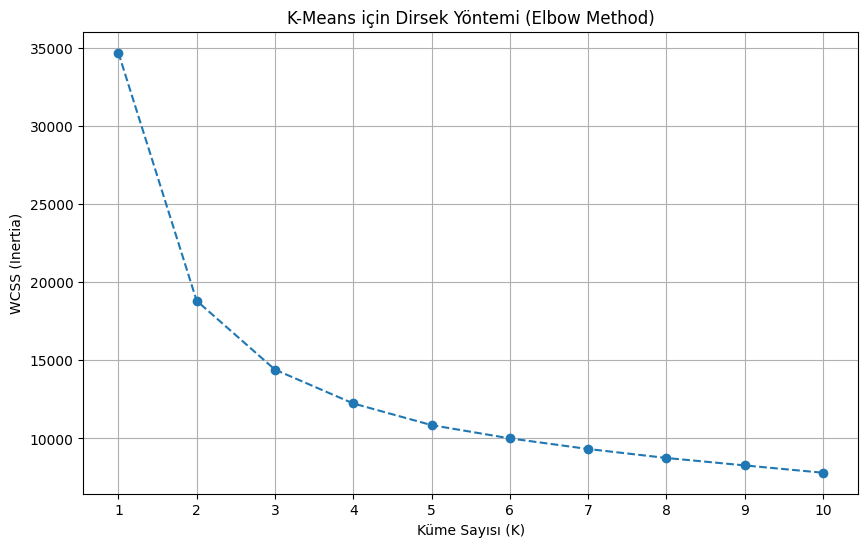

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
#K-Means Algoritması için optimum K değerini bulmaya çalışıyorum. Bunun için k değerini 0-10
#arası deneyeceğim. Dirsek noktası olarak gözüken yer genelde en iyisi olarak geçiyor. Bu ve
#buna en yakın değerleri deneyeceğim.

wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k,
                    init='k-means++',
                    n_init=10,
                    max_iter=300,
                    random_state=42)

    kmeans.fit(customer_data_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('K-Means için Dirsek Yöntemi (Elbow Method)')
plt.xlabel('Küme Sayısı (K)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

#Dirsek noktası olarak gözüken 2 ve ona en yakın yer olan 3 için k
#değerlerini deniyorum. En iyi skora sahip olanı alacağım

k_values_to_test = [2, 3]

silhouette_scores = {}
cluster_labels_map = {}

print("Silhouette Skorları Karşılaştırması")

X_scaled = customer_data_scaled

#Buradaki değerleri yapay zeka yardımıyla ve kütüphane dökümantasyonunu okuyarak belirledim.
#Başka değerler vermemin çok fazla değişikliğe neden açmadığını gözlemledim. Bu yüzden bu değerleri
#kabul ederek devam ettim. Örneğin n_init, max_iter değerlerini arttırıp azalttım ve hiçbir
#değişiklik gözlemlemedim. Algoritma için de dökümantasyondaki iki algoritmayı da denedim ve aynı
#şekilde hiçbir değişiklik olmadı. Bu yüzden default haliyle devam ettim ve yapay zekanın önerdiği
#şekilde algoritmayı geliştirdim.
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

for k in k_values_to_test:
    kmeans = KMeans(n_clusters=k,
                    init='k-means++',
                    n_init=10,
                    max_iter=300,
                    random_state=42)

    labels = kmeans.fit_predict(X_scaled)

    score = silhouette_score(X_scaled, labels)

    silhouette_scores[k] = score
    cluster_labels_map[k] = labels

    print(f"K={k} için Silhouette Skoru: {score:.4f}")



Silhouette Skorları Karşılaştırması
K=2 için Silhouette Skoru: 0.4157
K=3 için Silhouette Skoru: 0.3325


In [ ]:
optimum_k = 2
customer_data['Cluster'] = cluster_labels_map[optimum_k]

analysis_k2 = customer_data.groupby('Cluster').agg(
    CustomerCount=('Recency', 'count'),
    Recency_Mean=('Recency', 'mean'),
    Frequency_Mean=('Frequency', 'mean'),
    Monetary_Mean=('Monetary', 'mean'),
    AvgOrderValue_Mean=('AvgOrderValue', 'mean')
).sort_values(by='Monetary_Mean', ascending=False)


print("K-Means (K=2) Müşteri Segmentleri")
print(analysis_k2)

K-Means (K=2) Müşteri Segmentleri
         CustomerCount  Recency_Mean  Frequency_Mean  Monetary_Mean  \
Cluster                                                               
0                 2550     48.734902        6.414510    3232.962985   
1                 1788    155.005034        1.216443     373.239536   

         AvgOrderValue_Mean  
Cluster                      
0                486.120134  
1                323.678423  


In [ ]:
#AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering

#kütüphane sitesinden bakarak buradaki linkage metotları olduğunu gördüm ve en iyisi hangisi
#olduğunu anlamak için hepsi için silhouette skorlarına baktım
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

linkage_methods = ['ward', 'complete', 'average', 'single']

#K-Means için küme sayısını 2 kullandığımızdan aynı küme sayısını vermeliyim ki karşılaştırma
#yapabileyim. Ayrıca farklı metrikler deneneibilir. Ancak ben default değeri vermek istedim.
for method in linkage_methods:
    agg_cluster = AgglomerativeClustering(n_clusters=2,
                                          metric='euclidean',
                                          linkage=method)

    labels = agg_cluster.fit_predict(customer_data_scaled)

    #single bazen tek küme bularak hatalara sebep olabiliyormuş. Bu yüzden böyle bir try-expect
    #bloğu ekledim
    try:
        score = silhouette_score(customer_data_scaled, labels)
        print(f"Linkage = '{method}' | Silhouette Skoru: {score:.4f}")
    except ValueError as e:
        print(f"Linkage = '{method}' | Hata: {e} (Muhtemelen tek bir küme buldu)")

Linkage = 'ward' | Silhouette Skoru: 0.4154
Linkage = 'complete' | Silhouette Skoru: 0.1785
Linkage = 'average' | Silhouette Skoru: 0.6087
Linkage = 'single' | Silhouette Skoru: 0.6459


In [ ]:
agg_cluster_single = AgglomerativeClustering(n_clusters=2,
                                      metric='euclidean',
                                      linkage='single')

agg_labels_single = agg_cluster_single.fit_predict(customer_data_scaled)

customer_data['Cluster_Hierarchical_SINGLE'] = agg_labels_single
analysis_hierarchical_single = customer_data.groupby('Cluster_Hierarchical_SINGLE').agg(
    CustomerCount=('Recency', 'count'),
    Recency_Mean=('Recency', 'mean'),
    Frequency_Mean=('Frequency', 'mean'),
    Monetary_Mean=('Monetary', 'mean')
).sort_values(by='Monetary_Mean', ascending=False)

print("\nHiyerarşik Kümeleme (K=2) Sonuç Analizi (Single Linkage):")
print(analysis_hierarchical_single)


#Single daha iyi sonuç vermiş gibi gözüküyordu ancak aşağıdaki çıktılarda da görüldüğü gibi
#müşterileri 4337-1 gibi ayarsız bir şekilde kümeledi. Bu yüzden bu çıktı çok sağlıklı olmadı.
#Bu yüzden skorlarımızda ikinci olan average için aşağıdaki kod bloğunda tekrardan hesaplama yaptım


Hiyerarşik Kümeleme (K=2) Sonuç Analizi (Single Linkage):
                             CustomerCount  Recency_Mean  Frequency_Mean  \
Cluster_Hierarchical_SINGLE                                                
1                                        1      1.000000        2.000000   
0                                     4337     92.557528        4.272539   

                             Monetary_Mean  
Cluster_Hierarchical_SINGLE                 
1                            168472.500000  
0                              2015.894721  


In [ ]:
agg_cluster_avg = AgglomerativeClustering(n_clusters=2,
                                      metric='euclidean',
                                      linkage='average')

agg_labels_avg = agg_cluster_avg.fit_predict(customer_data_scaled)

customer_data['Cluster_Hierarchical_AVG'] = agg_labels_avg
analysis_hierarchical_avg = customer_data.groupby('Cluster_Hierarchical_AVG').agg(
    CustomerCount=('Recency', 'count'),
    Recency_Mean=('Recency', 'mean'),
    Frequency_Mean=('Frequency', 'mean'),
    Monetary_Mean=('Monetary', 'mean')
).sort_values(by='Monetary_Mean', ascending=False)

print("\nHiyerarşik Kümeleme (K=2) Sonuç Analizi (Average Linkage):")
print(analysis_hierarchical_avg)

#Burada da kümeleri çok gereksiz ayrı ayırdı. Bu yüzden en iyi skorlardan biri olduğu ve
#single'dan daha sağlıklı görüldüğü için karşılaştırmada bu değeri alacağım fakat daha yakın
#bölütleme istenirse metric=ward kullanılabilir. Onun için de hesaplamalarımı yaptım.


Hiyerarşik Kümeleme (K=2) Sonuç Analizi (Average Linkage):
                          CustomerCount  Recency_Mean  Frequency_Mean  \
Cluster_Hierarchical_AVG                                                
1                                     3    187.333333        2.000000   
0                                  4335     92.470819        4.273587   

                          Monetary_Mean  
Cluster_Hierarchical_AVG                 
1                          96730.133333  
0                           1988.746829  


In [ ]:
agg_cluster_ward = AgglomerativeClustering(n_clusters=2,
                                      metric='euclidean',
                                      linkage='ward')

agg_labels_ward = agg_cluster_ward.fit_predict(customer_data_scaled)

customer_data['Cluster_Hierarchical_Ward'] = agg_labels_ward
analysis_hierarchical_ward = customer_data.groupby('Cluster_Hierarchical_Ward').agg(
    CustomerCount=('Recency', 'count'),
    Recency_Mean=('Recency', 'mean'),
    Frequency_Mean=('Frequency', 'mean'),
    Monetary_Mean=('Monetary', 'mean')
).sort_values(by='Monetary_Mean', ascending=False)

print("\nHiyerarşik Kümeleme (K=2) Sonuç Analizi (Ward Linkage):")
print(analysis_hierarchical_ward)


Hiyerarşik Kümeleme (K=2) Sonuç Analizi (Ward Linkage):
                           CustomerCount  Recency_Mean  Frequency_Mean  \
Cluster_Hierarchical_Ward                                                
0                                   2769     57.018418        6.094258   
1                                   1569    155.219248        1.056087   

                           Monetary_Mean  
Cluster_Hierarchical_Ward                 
0                            2884.062991  
1                             589.826310  


In [ ]:
#BIRCH

from sklearn.cluster import Birch
import collections

#Kütüphane dökümantasyonunu inceledikten sonra k=2 sabit tutarak hangi değerleri verirsem daha
#iyi olur diye denemeler yaptım ve bunun için iç içe for ile en optimum değerleri bulmaya çalıştım
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html

threshold_values = [0.5, 0.8, 1.0, 1.5]
branching_factor_values = [50, 100, 200]

print("BIRCH Parametre Testleri (K=2)")

for thresh in threshold_values:
    for branch_factor in branching_factor_values:

        birch = Birch(n_clusters=2,
                      threshold=thresh,
                      branching_factor=branch_factor)

        labels_birch = birch.fit_predict(customer_data_scaled)

        if len(set(labels_birch)) < 2:
            print(f"threshold={thresh}, branching_factor={branch_factor} -> Sadece 1 küme bulundu, skor hesaplanamadı.")
            continue

        score_s_birch = silhouette_score(customer_data_scaled, labels_birch)

        distribution = collections.Counter(labels_birch)

        print(f"thresh={thresh}, branch={branch_factor} | Skor: {score_s_birch:.4f} | Dağılım: {distribution[0]}, {distribution[1]}")


BIRCH Parametre Testleri (K=2)
thresh=0.5, branch=50 | Skor: 0.3055 | Dağılım: 2658, 1680
thresh=0.5, branch=100 | Skor: 0.2738 | Dağılım: 3494, 844
thresh=0.5, branch=200 | Skor: 0.2680 | Dağılım: 3796, 542
thresh=0.8, branch=50 | Skor: 0.3986 | Dağılım: 2611, 1727
thresh=0.8, branch=100 | Skor: 0.2841 | Dağılım: 3227, 1111
thresh=0.8, branch=200 | Skor: 0.2317 | Dağılım: 3663, 675
thresh=1.0, branch=50 | Skor: 0.2995 | Dağılım: 1649, 2689
thresh=1.0, branch=100 | Skor: 0.3586 | Dağılım: 2413, 1925
thresh=1.0, branch=200 | Skor: 0.3121 | Dağılım: 1907, 2431
thresh=1.5, branch=50 | Skor: 0.3023 | Dağılım: 1237, 3101
thresh=1.5, branch=100 | Skor: 0.3023 | Dağılım: 1237, 3101
thresh=1.5, branch=200 | Skor: 0.3023 | Dağılım: 1237, 3101


In [ ]:
birch = Birch(n_clusters=2,
                      threshold=0.8,
                      branching_factor=50)

labels_birch = birch.fit_predict(customer_data_scaled)


customer_data['Cluster_BIRCH'] = labels_birch
analysis_birch = customer_data.groupby('Cluster_BIRCH').agg(
    CustomerCount=('Recency', 'count'),
    Recency_Mean=('Recency', 'mean'),
    Monetary_Mean=('Monetary', 'mean')
).sort_values(by='Monetary_Mean', ascending=False)

print("\nBIRCH (K=2) Sonuç Analizi:")
print(analysis_birch)


BIRCH (K=2) Sonuç Analizi:
               CustomerCount  Recency_Mean  Monetary_Mean
Cluster_BIRCH                                            
0                       2611     54.288012    3196.566121
1                       1727    150.363057     327.257534


In [ ]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

model_labels = {
    "K-Means (K=2)": cluster_labels,
    "BIRCH (t=0.8, b=50)": labels_birch,
    "Hiyerarşik (ward)": agg_labels_ward,
    "Hiyerarşik (average)": agg_labels_avg,
    "Hiyerarşik (single)": agg_labels_single
}


results = []
X_scaled = customer_data_scaled

print("Kümeleme Modeli Metrik Karşılaştırması")
print("Tüm metrikler K=2 (iki küme) için hesaplanmıştır.\n")

for model_name, labels in model_labels.items():

    score_sil = silhouette_score(X_scaled, labels)
    score_ch = calinski_harabasz_score(X_scaled, labels)
    score_db = davies_bouldin_score(X_scaled, labels)

    results.append({
        "Model": model_name,
        "Silhouette Skoru (Yüksek iyi)": score_sil,
        "Calinski-Harabasz Skoru (Yüksek iyi)": score_ch,
        "Davies-Bouldin Skoru (Düşük iyi)": score_db
    })

df_results = pd.DataFrame(results).set_index("Model")
print(df_results.to_markdown(floatfmt=".4f"))

print("\n Küme Dağılımları (Müşteri Sayıları)")

distributions = {}
for model_name, labels in model_labels.items():
    counts = collections.Counter(labels)
    distributions[model_name] = {'Düzenli Müşteriler': counts[0], 'Kayıp Müşteriler': counts[1]}

df_dist = pd.DataFrame.from_dict(distributions, orient='index')
print(df_dist.to_markdown())

Kümeleme Modeli Metrik Karşılaştırması
Tüm metrikler K=2 (iki küme) için hesaplanmıştır.

| Model                |   Silhouette Skoru (Yüksek iyi) |   Calinski-Harabasz Skoru (Yüksek iyi) |   Davies-Bouldin Skoru (Düşük iyi) |
|:---------------------|--------------------------------:|---------------------------------------:|-----------------------------------:|
| K-Means (K=2)        |                          0.4157 |                              3660.6506 |                             0.9585 |
| BIRCH (t=0.8, b=50)  |                          0.3986 |                              3376.0019 |                             0.9853 |
| Hiyerarşik (ward)    |                          0.4154 |                              3359.9859 |                             0.9477 |
| Hiyerarşik (average) |                          0.6087 |                                29.1523 |                             0.5985 |
| Hiyerarşik (single)  |                          0.6459 |                              

Normalde sadece Sillhouete Skorlarına bakarak seçtiğimizde en iyi olarak Agglomerative Clustering'te metric olarak single, sonrasında average gözüküyordu. Fakat bu bölütlemelerin çok iyi olmadığı diğer skorlara bakılınca da belli oluyor. Bu durumda bütün skorlar ve bölütlemeyle en iyisinin **K-Means** olduğu ve sıralamanın şöyle olduğu anlaşılıyor:
***K-Means> Agglomerative Clustering (ward) > BIRCH> AgglomerativeClustering (average)> AgglomerativeClustering (single)***

Ayrıca hesaplamalarımıza bakılınca 0 kümesi için: "Düzenli Müşteriler", 1 kümesi için: "Kayıp Müşteriler" demek uygundur ve bu yüzden en son karşılaştırma tablosunda isimler böyle adlandırılmıştır.